<a href="https://colab.research.google.com/github/anushkamandal25/EEG-Classification/blob/master/Mainfile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/MyDrive/EEG-Classification-master/

/content/drive/MyDrive/EEG-Classification-master


In [ ]:
ls

 1.EEG_Signal_Classification_GoogleColab_Final_Code.ipynb
 data/
 eeg_learn_functions.py
'Final_Code_Experimental (1).ipynb'
 Final_Code_Experimental.ipynb
 Final_Code_Run.html
 Final_Code_Run.ipynb
 galvanize_36x48_Tevis_Gehr_EEG_2.pdf
 galvanize_36x48_Tevis_Gehr_EEG.key
'image_classification_with_vision_transformer (1).ipynb'
 image_classification_with_vision_transformer.ipynb
 Initial_EDA.ipynb
 Pictures/
 __pycache__/
 README.md
 Rev1-1.ipynb
 Rev1.ipynb
 train_pipeline_2.py
 train_pipeline_3.py
 train_pipeline_4.py
 train_pipeline_5_no_overlap.py
 train_pipeline.py


In [ ]:
from eeg_learn_functions import *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [ ]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [ ]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [ ]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [ ]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [ ]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [ ]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [ ]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [ ]:
file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv',
              'data/ML102_KS.csv',
              'data/ML102_US.csv',
              'data/ML103_KS.csv',
              'data/ML103_US.csv',
              'data/ML104_KS.csv',
              'data/ML104_US.csv',
              'data/ML105_KS.csv',
              'data/ML105_US.csv',
              'data/ML106_KS.csv',
              'data/ML106_US.csv',
              'data/ML107_KS.csv',
              'data/ML107_US.csv',
              'data/ML108_KS.csv',
              'data/ML108_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  16 )
234  frames generated with label  1 .


Processing session:  data/ML101_US.csv . ( 2  of  16 )
224  frames generated with label  0 .


Processing session:  data/ML102_KS.csv . ( 3  of  16 )
222  frames generated with label  1 .


Processing session:  data/ML102_US.csv . ( 4  of  16 )
218  frames generated with label  0 .


Processing session:  data/ML103_KS.csv . ( 5  of  16 )
226  frames generated with label  1 .


Processing session:  data/ML103_US.csv . ( 6  of  16 )
208  frames generated with label  0 .


Processing session:  data/ML104_KS.csv . ( 7  of  16 )
202  frames generated with label  1 .


Processing session:  data/ML104_US.csv . ( 8  of  16 )
204  frames generated with label  0 .


Processing session:  data/ML105_KS.csv . ( 9  of  16 )
214  frames generated with label  1 .


Processing session:  data/ML105_US.csv . ( 10  of  16 )
226  frames generated with label  0 .


Processing session:  

In [ ]:
X.shape

(3642, 28, 28, 3)

In [ ]:
y.shape

(3642,)

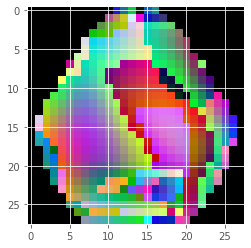

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow()
plt.imshow((X[0] * 255).astype(np.uint8))

In [ ]:
from eeg_learn_functions import *


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4


In [ ]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)


In [ ]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [ ]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [ ]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128
    i = 0
    intervals = []
    samples_per_frame = Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [ ]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

In [ ]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [ ]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',').T
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
        
    return X,np.array(y)

In [ ]:
file_names = ['data/ML101_KS.csv',
              'data/ML101_US.csv',
              'data/ML102_KS.csv',
              'data/ML102_US.csv',
              'data/ML103_KS.csv',
              'data/ML103_US.csv',
              'data/ML104_KS.csv',
              'data/ML104_US.csv',
              'data/ML105_KS.csv',
              'data/ML105_US.csv',
              'data/ML106_KS.csv',
              'data/ML106_US.csv',
              'data/ML107_KS.csv',
              'data/ML107_US.csv',
              'data/ML108_KS.csv',
              'data/ML108_US.csv']
labels = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/ML101_KS.csv . ( 1  of  16 )
234  frames generated with label  1 .


Processing session:  data/ML101_US.csv . ( 2  of  16 )
224  frames generated with label  0 .


Processing session:  data/ML102_KS.csv . ( 3  of  16 )
222  frames generated with label  1 .


Processing session:  data/ML102_US.csv . ( 4  of  16 )
218  frames generated with label  0 .


Processing session:  data/ML103_KS.csv . ( 5  of  16 )
226  frames generated with label  1 .


Processing session:  data/ML103_US.csv . ( 6  of  16 )
208  frames generated with label  0 .


Processing session:  data/ML104_KS.csv . ( 7  of  16 )
202  frames generated with label  1 .


Processing session:  data/ML104_US.csv . ( 8  of  16 )
204  frames generated with label  0 .


Processing session:  data/ML105_KS.csv . ( 9  of  16 )
214  frames generated with label  1 .


Processing session:  data/ML105_US.csv . ( 10  of  16 )
226  frames generated with label  0 .


Processing session:  

In [ ]:
X.shape


(3642, 28, 28, 3)

In [ ]:
y.shape

(3642,)

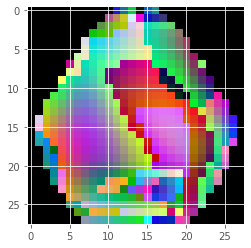

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow()
plt.imshow((X[0] * 255).astype(np.uint8))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [ ]:
y_train.shape

(2913,)

In [ ]:
x_train.shape

(2913, 28, 28, 3)

In [ ]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (2913, 28, 28, 3)
2913 train samples
729 test samples


In [ ]:
np.mean(x_train)

1.7340571

In [ ]:
from tensorflow import keras 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
#from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [ ]:
from tensorflow import keras 
from tensorflow.keras.callbacks import History 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
#from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 32
num_classes = 2
epochs = 200

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
history = History()

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/200
92/92 [==============================] - 8s 80ms/step - loss: 0.6918 - accuracy: 0.5009 - val_loss: 0.7216 - val_accuracy: 0.4897
Epoch 2/200
92/92 [==============================] - 7s 72ms/step - loss: 0.6872 - accuracy: 0.5002 - val_loss: 0.6910 - val_accuracy: 0.4897
Epoch 3/200
92/92 [==============================] - 9s 97ms/step - loss: 0.6839 - accuracy: 0.5173 - val_loss: 0.6863 - val_accuracy: 0.5048
Epoch 4/200
92/92 [==============================] - 9s 96ms/step - loss: 0.6807 - accuracy: 0.5266 - val_loss: 0.6994 - val_accuracy: 0.4856
Epoch 5/200
92/92 [==============================] - 7s 72ms/step - loss: 0.6757 - accuracy: 0.5379 - val_loss: 0.6803 - val_accuracy: 0.4966
Epoch 6/200
92/92 [==============================] - 7s 72ms/step - loss: 0.6709 - accuracy: 0.5517 - val_loss: 0.6828 - val_accuracy: 0.5967
Epoch 7/200
92/92 [==============================] - 7s 73ms/step - loss: 0.6672 - accuracy: 0.5709 - val_loss: 0.6765 - val_accuracy: 0.5761
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


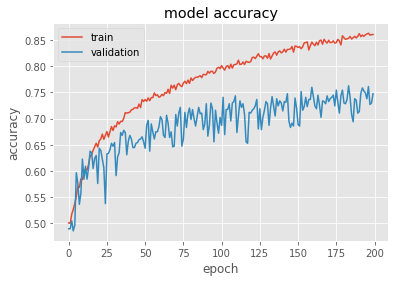

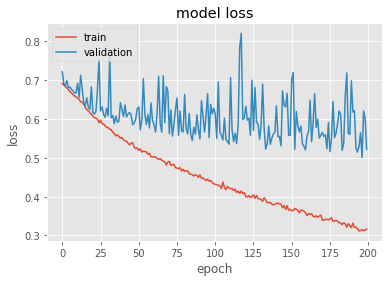

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                        